# TSeries de tiempo Ivan Trujillo- Acuña

## 1.

### Lectura de datos y EDA

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import yfinance as yf
from yahoo_fin.stock_info import get_data
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [3]:
msft = yf.Ticker("BTC-USD")


Podemos ver los datos basicos de la accion, tales como su valor actual.

In [4]:
sns.set_theme()
sns.set_context("paper")

In [5]:
stock = 'BTC-USD'
resolution = '1d'
end_date = datetime.now()
start_date = 1278979200

 Como estamos interesados en predecir el valor del día nuestra resolucion es de un día.

In [6]:
def date_format(date_h):
    return date_h.strftime('%d/%m/%Y')

In [7]:
BTC_df = get_data(stock, start_date=start_date, end_date=end_date, interval=resolution, index_as_date=False)
BTC_df.head()

date        open        high         low       close    adjclose  \
0 2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1 2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2 2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3 2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4 2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

       volume   ticker  
0  21056800.0  BTC-USD  
1  34483200.0  BTC-USD  
2  37919700.0  BTC-USD  
3  36863600.0  BTC-USD  
4  26580100.0  BTC-USD

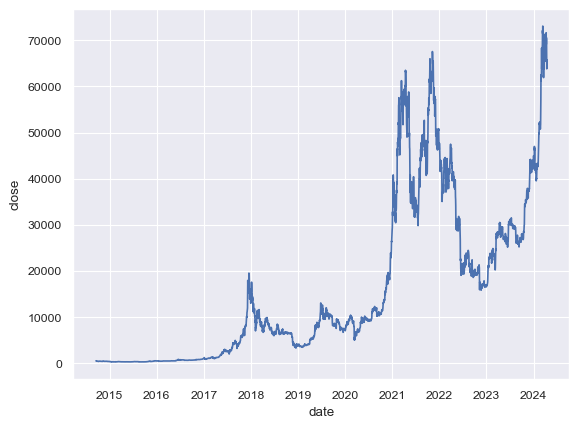

In [8]:
sns.lineplot(data=BTC_df, x=BTC_df.date, y=BTC_df.close);

Al graficar los datos observamos un dinamismo en el valor de los BTC.

In [9]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x = BTC_df.date,
                                     open = BTC_df.open, 
                                     high = BTC_df.high,
                                     low = BTC_df.low, 
                                     close = BTC_df.close)
                     ])
fig.update_layout(
    title="Bitcoin. (BTC)",
    xaxis_title="Day",
    yaxis_title="BTC-USD",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)
fig.update_layout(xaxis_rangeslider_visible=False)
fig

Se grafica tambien un candlestick para facilitar la visualizacion.

### Pruebas estadisticas

Antes de comenzar a pronosticar decidimos realizar algunas pruebas estadisticas para confirmar la viabilidad del modelo ARIMA.

In [10]:
result = adfuller(BTC_df.close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: nan
p-value: nan


Al p-value ser mayor a 0.05 no rechazamos la hipotesis nula, por lo cual la serie estadisticamente no es estacionaria.

In [11]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
from statsmodels.tsa.stattools import acf

def plotly_acf_with_confidence(data, lags):
    acf_vals, conf_int = acf(data, nlags=lags, alpha=0.05, fft=True)  # Obtener ACF y intervalos de confianza
    lower_bound = conf_int[:, 0]  # límite inferior
    upper_bound = conf_int[:, 1]  # límite superior
    
    traces = [
        go.Scatter(
            x=list(range(lags+1)), y=acf_vals, mode='lines', name='ACF',
            line=dict(color='blue'),
            fill='tozeroy',  # Relleno hasta el eje x
            fillcolor='rgba(0, 100, 255, 0.2)'
        ),
        go.Scatter(
            x=list(range(lags+1)) + list(range(lags+1))[::-1],  # x, luego x reversa
            y=np.concatenate([upper_bound, lower_bound[::-1]]),  # upper, luego lower reversa
            fill='toself', fillcolor='rgba(0, 100, 255, 0.3)', line=dict(color='rgba(255,255,255,0)'),
            showlegend=False  # Ocultar leyenda para este trazo
        )
    ]
    return traces

# Suponiendo que tienes 'BTC_df' cargado y listo, y la columna 'close' tiene los precios de cierre
fig = make_subplots(rows=3, cols=2, subplot_titles=("Original Series", "ACF of Original",
                                                    "1st Order Differencing", "ACF of 1st Differencing",
                                                    "2nd Order Differencing", "ACF of 2nd Differencing"))

# Añadiendo las series y los ACF con intervalos de confianza
fig.add_trace(go.Scatter(x=BTC_df.index, y=BTC_df.close, mode='lines', showlegend=False), row=1, col=1)
fig.add_traces(plotly_acf_with_confidence(BTC_df.close, 3497), rows=[1,1], cols=[2,2])

# Primera diferenciación
first_diff = BTC_df.close.diff().dropna()
fig.add_trace(go.Scatter(x=BTC_df.index[1:], y=first_diff, mode='lines', showlegend=False), row=2, col=1)
fig.add_traces(plotly_acf_with_confidence(first_diff, 3496), rows=[2,2], cols=[2,2])

# Segunda diferenciación
second_diff = BTC_df.close.diff().diff().dropna()
fig.add_trace(go.Scatter(x=BTC_df.index[2:], y=second_diff, mode='lines', showlegend=False), row=3, col=1)
fig.add_traces(plotly_acf_with_confidence(second_diff, 3495), rows=[3,3], cols=[2,2])

# Actualizar layout para mejorar la visualización
fig.update_layout(height=1200, width=1000, title_text="BTC Price Analysis with Interactive ACF Plots")
fig.show()




Graficamos las auto-correlaciones de la grafica original, la de difereciacion de orden 1 y de orden 2. El decaimiento geometrico en la primera grafica nos hace confirmar que la serie de tiempo no es estacionaria, ademas podemos ver que la grafica de diferenciacion de orden 2 entra al lado negativo con rapidez, esto puede ser debido a que esta sobrediferenciada.

## 2. 

In [12]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.graphics.tsaplots import plot_predict
warnings.filterwarnings("ignore")

Hacemos el llamado de la libreria.

In [13]:
def arima_rolling(history, test, orderb):
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=orderb)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        
    return predictions

Definimos la funcion para trabajar en la metodologia rolling forecast.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def forecast_accuracy(predictions_list, actual, title_prefix=""):
    # Asumiendo que 'actual' es una serie o arreglo que contiene los valores reales
    
    results = []
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 18))
    metrics = ['MAE', 'MSE', 'MAPE', 'RMSE', 'R2']
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    for idx, forecast in enumerate(predictions_list):
        days_predicted = len(forecast)
        str_name = f"{title_prefix} {days_predicted} days"
        
        # Calculo de errores
        mape = np.mean(np.abs(forecast - actual[:days_predicted]) / np.abs(actual[:days_predicted]))  # MAPE
        mae = np.mean(np.abs(forecast - actual[:days_predicted]))  # MAE
        rmse = np.mean((forecast - actual[:days_predicted])**2)**.5  # RMSE
        mse = np.mean((forecast - actual[:days_predicted])**2)  # MSE
        r2 = r2_score(actual[:days_predicted], forecast)  # R2
        
        results.append({
            'Days': days_predicted,
            'MAE': mae,
            'MSE': mse,
            'MAPE': mape,
            'RMSE': rmse,
            'R2': r2
        })
    
    # Crear un DataFrame para los resultados
    df_results = pd.DataFrame(results)
    
    # Graficar cada métrica
    for i, metric in enumerate(metrics):
        axes[i].plot(df_results['Days'], df_results[metric], label=metric, color=colors[i], marker='o')
        axes[i].set_title(f"{metric} by days predicted")
        axes[i].set_xlabel('Days')
        axes[i].set_ylabel(metric)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    return df_results


ModuleNotFoundError: No module named 'sklearn'

Se define esta funcion para el calculo de las metricas de error. 

In [ ]:
import numpy as np
import scipy.stats as stats
from statsmodels.stats.diagnostic import acorr_ljungbox

def analyze_residuals(predictions_list, actual_data):
    results = []

    for idx, prediction in enumerate(predictions_list):
        # Asumimos que 'actual_data' tiene suficientes datos para comparar con cada 'prediction'
        actual_subset = actual_data[:len(prediction)]
        
        # Calcular residuos
        residuals = np.array(actual_subset) - np.array(prediction)
        
        # Prueba de normalidad (Shapiro-Wilk)
        shapiro_test = stats.shapiro(residuals)
        shapiro_pvalue = shapiro_test.pvalue
        
        # Prueba de independencia (Ljung-Box)
        # El número de lags recomendado por defecto es min(10, len(residuals) // 5)
        lb_lags = min(10, len(residuals) // 5)
        lb_test = acorr_ljungbox(residuals, lags=[lb_lags], return_df=True)
        
        # Almacenar resultados
        results.append({
            'Prediction Length': len(prediction),
            'Shapiro P-Value': shapiro_pvalue,
            'Ljung-Box P-Value': lb_test['lb_pvalue'].iloc[0]
        })
        
        # Imprimir conclusiones
        print(f"Residuos para la predicción de {len(prediction)} días:")
        print(f"Test de Shapiro-Wilk P-Value: {shapiro_pvalue:.4f}")
        if shapiro_pvalue < 0.05:
            print("Rechazar la hipótesis nula: Los residuos no son normales.")
        else:
            print("No rechazar la hipótesis nula: Los residuos parecen ser normales.")
        
        print(f"Test de Ljung-Box P-Value: {lb_test['lb_pvalue'].iloc[0]:.4f}")
        if lb_test['lb_pvalue'].iloc[0] < 0.05:
            print("Rechazar la hipótesis nula: Los residuos muestran autocorrelación significativa.")
        else:
            print("No rechazar la hipótesis nula: Los residuos parecen ser independientes.")
        print("\n")
        
    return results

Se crea esta funcion para facilitar las pruebas de normalidad e independencia de los residuales de cada intervalo de prediccion.

In [ ]:
n_BTC = len(BTC_df.close); n_test = 28 
train_size = n_BTC - n_test
train = BTC_df.close[:train_size]
dates_train = BTC_df.date[:train_size]
test_4w = BTC_df.close[train_size:train_size + n_test] 
dates_4w = BTC_df.date[train_size:train_size + n_test] 
print("train:", train.shape)
print("test_4w:", test_4w.shape)

train: (3470,)
test_4w: (28,)


Definimos y dividimos el training y el test

In [ ]:
train_df = BTC_df[["close"]][:train_size]
test_4w_df = BTC_df[["close"]][train_size:train_size + n_test] 

Organizamos el df en train y test dejando los ultimos 28 días para el testing.

In [ ]:
best_aic = np.inf

best_order = None
best_mdl = None

pq_rng = range(5)
d_rng  = range(3)

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                # print(i, d, j)
                tmp_mdl = ARIMA(train, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

Hacemos la hyperparametrizacion del modelo con los parametros moviendose del 1 al 10 usando la metrica aic.

In [ ]:
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 56295.88868 | order: (3, 2, 4)


Podemos ver que los mejores parametros segun la metrica aic son (3, 2, 4).

In [ ]:
model_aic = ARIMA(train, order=best_order)
model_fit_aic = model_aic.fit()

Entrenamos el modelo con los mejores parametros encontrados.

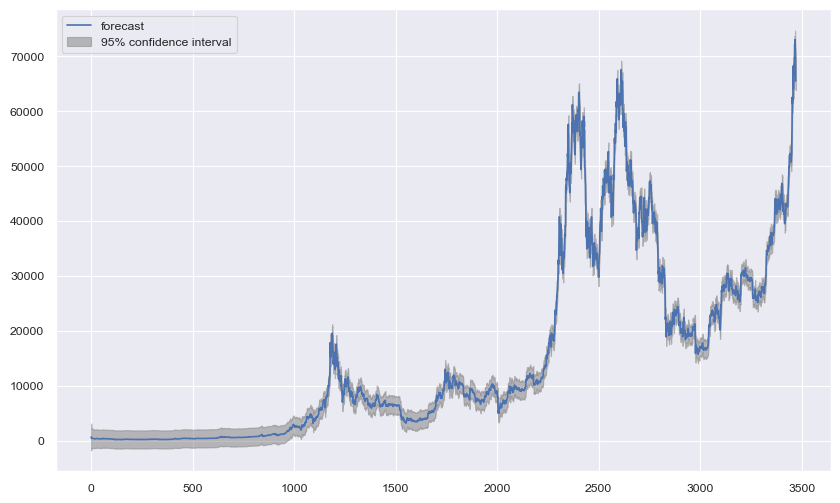

In [ ]:
plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots();
plot_predict(model_fit_aic, 1, ax=ax);
plt.show();

Graficamos el intervalo de confianza del 95% para nuestras predicciones.

In [ ]:
test_range = range(4)
predictions_roll_aic = []
for i in test_range:
    test = test_4w.head(7*(i+1))
    test = test.tolist()
    yhat  = arima_rolling(train.tolist(), test, best_order)
    predictions_roll_aic.append(yhat)

En esta funcion estamos haciendo el rolling forecast para los intervalos de 7,14,21 y 28 días.

In [ ]:
results = analyze_residuals(predictions_roll_aic,test_4w)

Residuos para la predicción de 7 días:
Test de Shapiro-Wilk P-Value: 0.7373
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.1296
No rechazar la hipótesis nula: Los residuos parecen ser independientes.


Residuos para la predicción de 14 días:
Test de Shapiro-Wilk P-Value: 0.4232
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.3658
No rechazar la hipótesis nula: Los residuos parecen ser independientes.


Residuos para la predicción de 21 días:
Test de Shapiro-Wilk P-Value: 0.3687
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.5013
No rechazar la hipótesis nula: Los residuos parecen ser independientes.


Residuos para la predicción de 28 días:
Test de Shapiro-Wilk P-Value: 0.7656
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.5265
No rechazar la hipótesis nula: Los residuos parecen ser independientes.

Al utilizar la funcion definida anteriormente podemos ver que todos los supuestos se cumplen para cada residual, por lo que concluimos que el modelo capta la variabilidad de los datos y es posible confiar en las predicciones.

## 3. Repita el paso 2 ahora sin utilizar rolling. 

In [ ]:
test_range = range(4)
predictions_for_aic = []

for i in test_range:
    # Hacer las predicciones para el siguiente intervalo de tiempo
    num_steps = 7 * (i + 1)  # Calculando el número de pasos a predecir
    yhat = model_fit_aic.forecast(steps=num_steps)
    predictions_for_aic.append(yhat)

In [ ]:
results = analyze_residuals(predictions_for_aic,test_4w)

Residuos para la predicción de 7 días:
Test de Shapiro-Wilk P-Value: 0.3997
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.0792
No rechazar la hipótesis nula: Los residuos parecen ser independientes.


Residuos para la predicción de 14 días:
Test de Shapiro-Wilk P-Value: 0.1172
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.0402
Rechazar la hipótesis nula: Los residuos muestran autocorrelación significativa.


Residuos para la predicción de 21 días:
Test de Shapiro-Wilk P-Value: 0.1362
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.1099
No rechazar la hipótesis nula: Los residuos parecen ser independientes.


Residuos para la predicción de 28 días:
Test de Shapiro-Wilk P-Value: 0.0445
Rechazar la hipótesis nula: Los residuos no son normales.
Test de Ljung-Box P-Value: 0.0416
Rechazar la hipótesis nula: Los residuos muestran autocorrelación sign

No se cumple el supuesto de independencia.

## 4. 

### Rolling Forecast

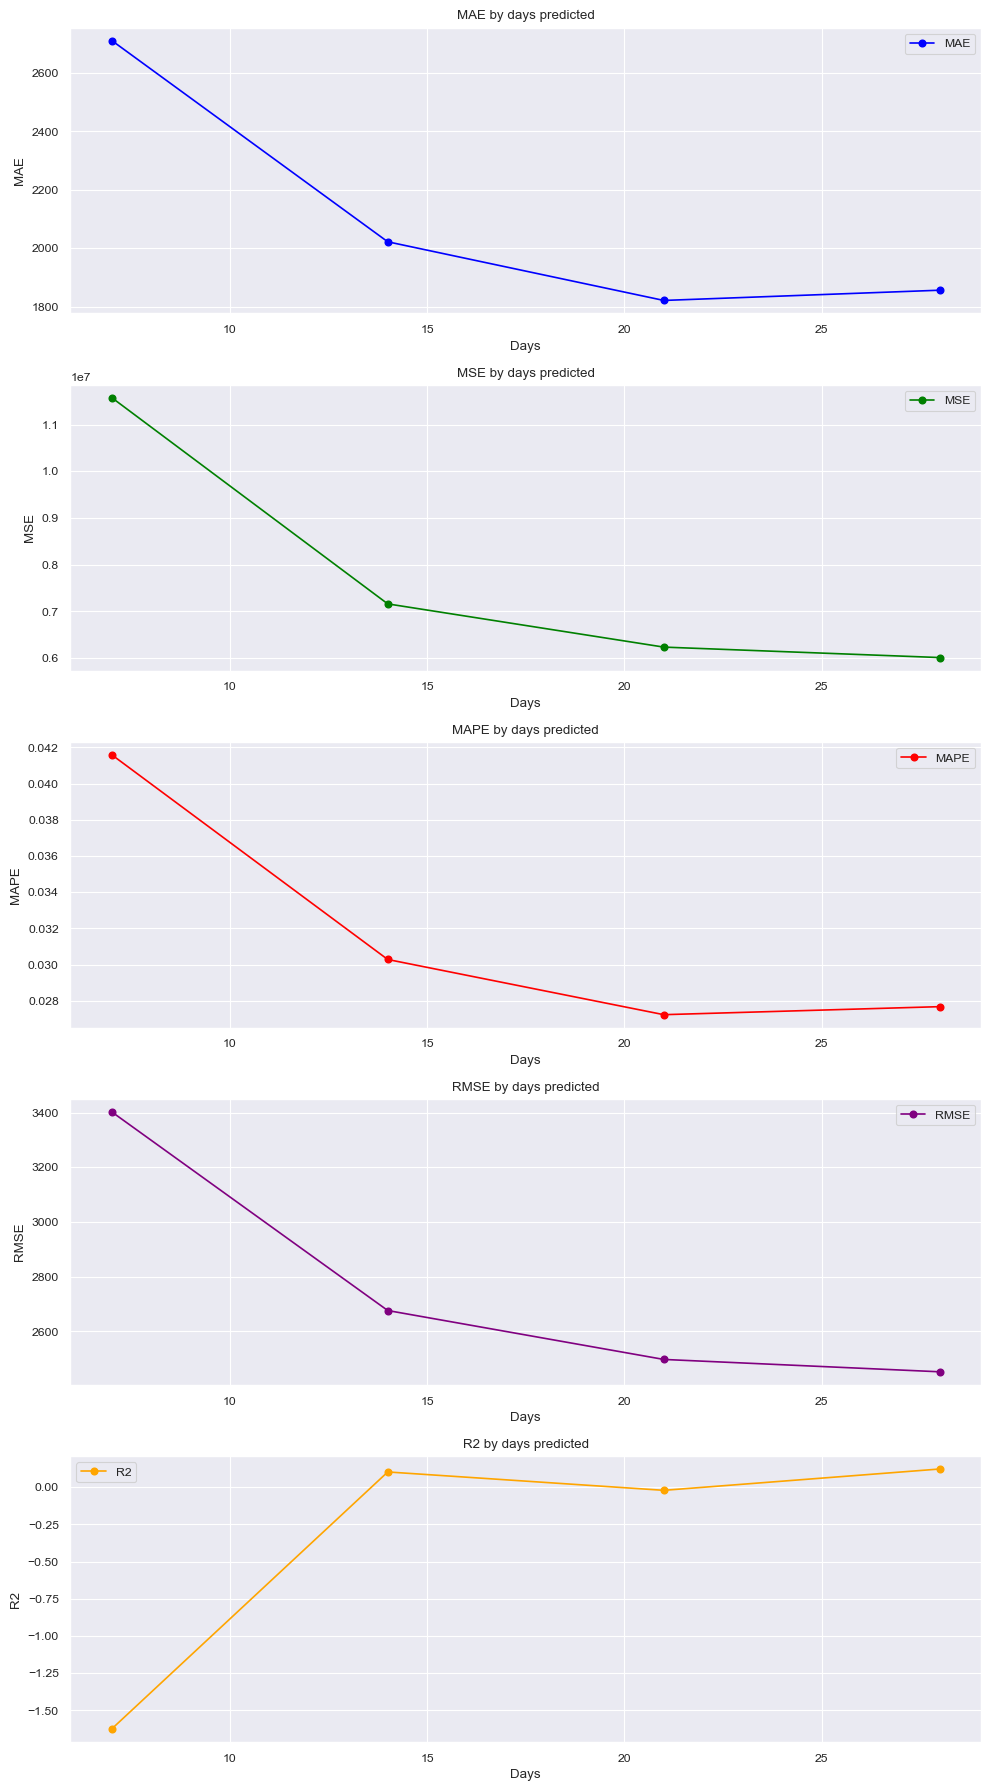

In [ ]:
roll_aic = forecast_accuracy(predictions_roll_aic, test_4w, title_prefix="Forecast")

Graficamos los resultados mejoran al aumentar el intervalo de prediccion.

Vemos que el R^2 tiene valores negativos.

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np

def plot_prediction_correlation(actual, predictions_list):
    # Crear subplots, uno para cada conjunto de predicciones
    num_predictions = len(predictions_list)
    fig = make_subplots(rows=num_predictions, cols=1, 
                        subplot_titles=[f'Correlacion de {len(pred)} dias predichos' for pred in predictions_list],
                        vertical_spacing=0.1)

    for i, predictions in enumerate(predictions_list):
        # Asegurarse de que los datos reales y las predicciones estén alineados
        actual_subset = actual[:len(predictions)]

        # Calcular coeficientes de correlación
        correlation_matrix = np.corrcoef(actual_subset, predictions)
        correlation_xy = correlation_matrix[0,1]
        r_squared = correlation_xy**2

        # Añadir gráfico de dispersión para cada conjunto de predicciones
        fig.add_trace(
            go.Scatter(
                x=actual_subset, y=predictions, mode='markers',
                marker=dict(size=8, color='blue', opacity=0.5),
                name=f'R^2: {r_squared:.2f}'
            ), 
            row=i+1, col=1
        )
        
        # Ajustar una línea de regresión lineal
        z = np.polyfit(actual_subset, predictions, 1)
        p = np.poly1d(z)
        fig.add_trace(
            go.Scatter(
                x=actual_subset, y=p(actual_subset), mode='lines',
                line=dict(color='red', dash='dash'),
                name='Fit'
            ),
            row=i+1, col=1
        )

        # Actualizar ejes para cada subplot
        fig.update_xaxes(title_text="Valores Reales", row=i+1, col=1)
        fig.update_yaxes(title_text="Valores Predichos", row=i+1, col=1)

    # Actualizar layout del gráfico
    fig.update_layout(
        height=300 * num_predictions, width=800,
        title_text="Correlacion entre predichos y verdaderos",
        showlegend=False
    )
    
    fig.show()

Creamos una funcion para graficar las correlaciones entre el valor real y predicho de cada intervalo de tiempo

In [ ]:
plot_prediction_correlation(test_4w, predictions_roll_aic)

Vemos que a excepcion de el intervalo de 7 días todoso tienen una tendencia positiva, ademas, los mejores R^2 estan para el intervalo de 28 y 14 dias.

### Forecast

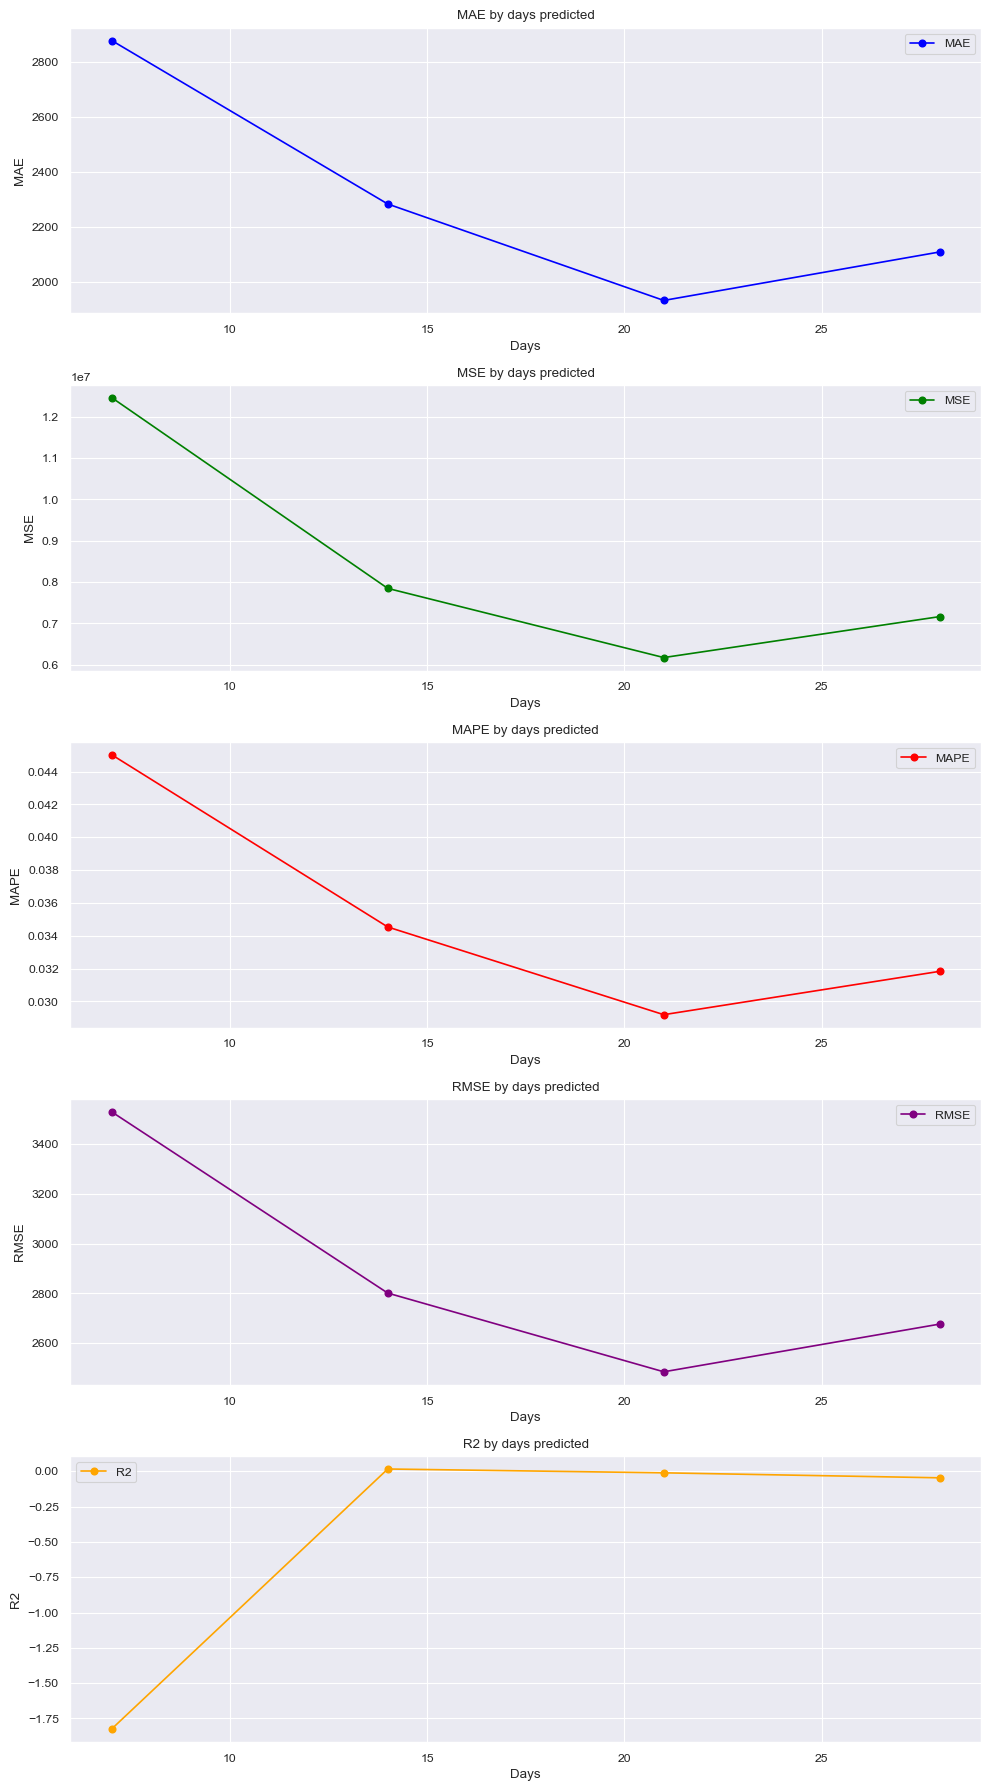

In [ ]:
for_aic = forecast_accuracy(predictions_for_aic, test_4w, title_prefix="Forecast")

Parece que el mejor intervalo es a 21 días.

Vemos que el R^2 tiene valores negativos, esto ocurre debido a varios factores como:
- Datos limitados
- Sobreajuste
- Variacion Aleatoria

In [ ]:
plot_prediction_correlation(test_4w, predictions_for_aic)

Todos los intervalos tienen una tendencia positiva,y el mejor R^2 esta a 14 días.

### Comparaciones

In [ ]:
import matplotlib.pyplot as plt

def plot_comparative_metrics(df1, df2):
    metrics = ['MAE', 'MSE', 'MAPE', 'RMSE', 'R2']
    num_metrics = len(metrics)
    intervals = df1.index  # Asumimos que el índice es el intervalo de días
    width = 0.35  # Ancho de las barras

    # Crear una figura grande para contener todos los subplots
    fig, axes = plt.subplots(nrows=num_metrics, ncols=1, figsize=(10, 6 * num_metrics))

    for i, metric in enumerate(metrics):
        ax = axes[i]  # Acceder al subplot correspondiente
        # Graficar las barras para DF1
        ax.bar(intervals - width/2, df1[metric], width, label='Rolling', color='blue')
        # Graficar las barras para DF2
        ax.bar(intervals + width/2, df2[metric], width, label='Forecast', color='orange')

        ax.set_title(f'Comparación de {metric}')
        ax.set_ylabel(metric)
        ax.legend()

    axes[-1].set_xlabel('Intervalos de días')  # Etiqueta del eje x solo en el último gráfico
    axes[-1].set_xticks(intervals)  # Asegurar que todos los intervalos estén etiquetados

    plt.tight_layout()
    plt.show()

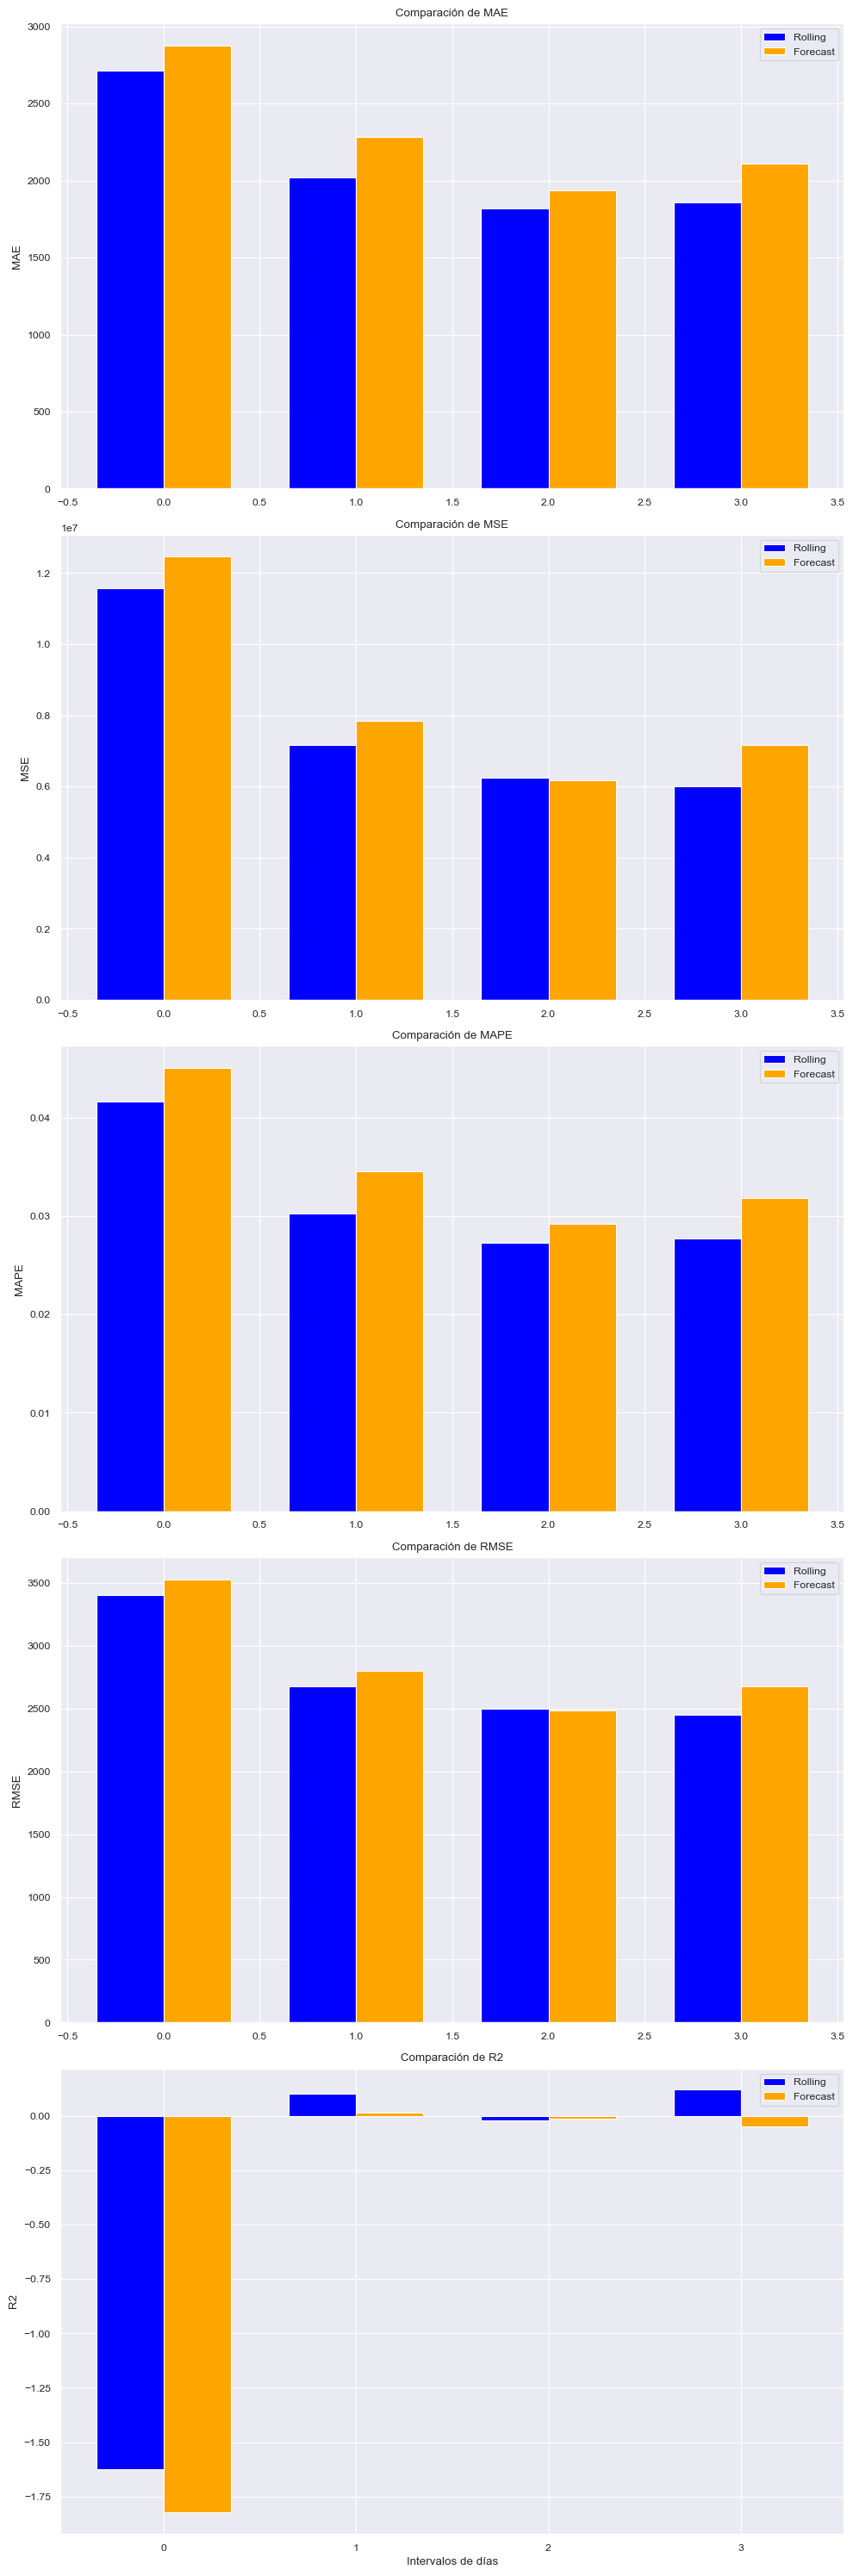

In [ ]:
plot_comparative_metrics(roll_aic, for_aic)

En terminos generales el rolling forecast es mejor, debido a que minimiza la mayoria de los errores.

## 5. 

### BIC

In [ ]:
best_bic = np.inf

best_order = None
best_mdl = None

pq_rng = range(5)
d_rng  = range(3)

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                # print(i, d, j)
                tmp_mdl = ARIMA(train, order=(i,d,j)).fit()
                tmp_bic = tmp_mdl.bic
                if tmp_bic < best_bic:
                    best_bic = tmp_bic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

Volvemos a correr la hyperparametrizacion esta vez optimizando el bic

In [ ]:
print('bic: {:6.5f} | order: {}'.format(best_bic, best_order))

bic: 56327.16155 | order: (0, 2, 1)


In [ ]:
model_bic = ARIMA(train, order=best_order)
model_fit_bic = model_bic.fit()

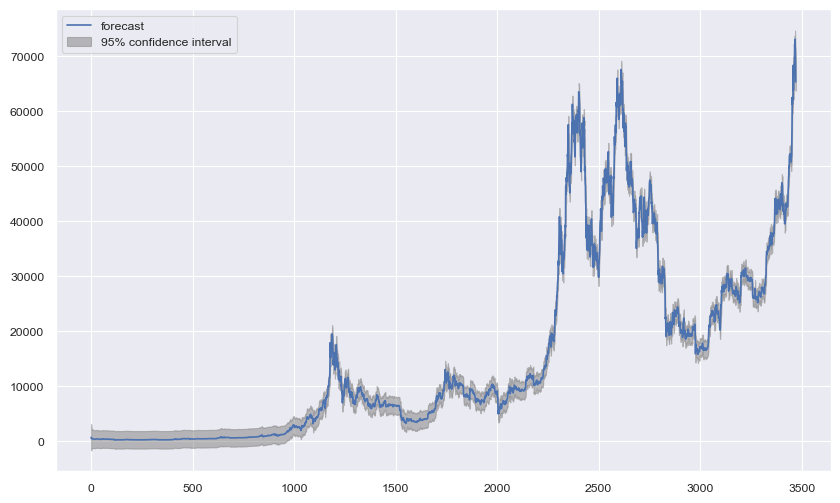

In [ ]:
plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots();
plot_predict(model_fit_bic, 1, ax=ax);
plt.show();

Graficamos el intervalo de confianza del 95% para nuestro nuevo modelo.

#### Rolling Forecast

In [ ]:
test_range = range(4)
predictions_roll_bic = []
for i in test_range:
    test = test_4w.head(7*(i+1))
    test = test.tolist()
    yhat  = arima_rolling(train.tolist(), test, best_order)
    predictions_roll_bic.append(yhat)

Hacemos el rolling forecast para el nuevo modelo

In [ ]:
results = analyze_residuals(predictions_roll_bic,test_4w)

Residuos para la predicción de 7 días:
Test de Shapiro-Wilk P-Value: 0.9388
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.1408
No rechazar la hipótesis nula: Los residuos parecen ser independientes.


Residuos para la predicción de 14 días:
Test de Shapiro-Wilk P-Value: 0.8911
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.3486
No rechazar la hipótesis nula: Los residuos parecen ser independientes.


Residuos para la predicción de 21 días:
Test de Shapiro-Wilk P-Value: 0.8613
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.5638
No rechazar la hipótesis nula: Los residuos parecen ser independientes.


Residuos para la predicción de 28 días:
Test de Shapiro-Wilk P-Value: 0.9871
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.6047
No rechazar la hipótesis nula: Los residuos parecen ser independientes.

Cumple todos los supuestos, por lo que concluimos que el modelo capta la variabilidad de los datos y es posible confiar en las predicciones.

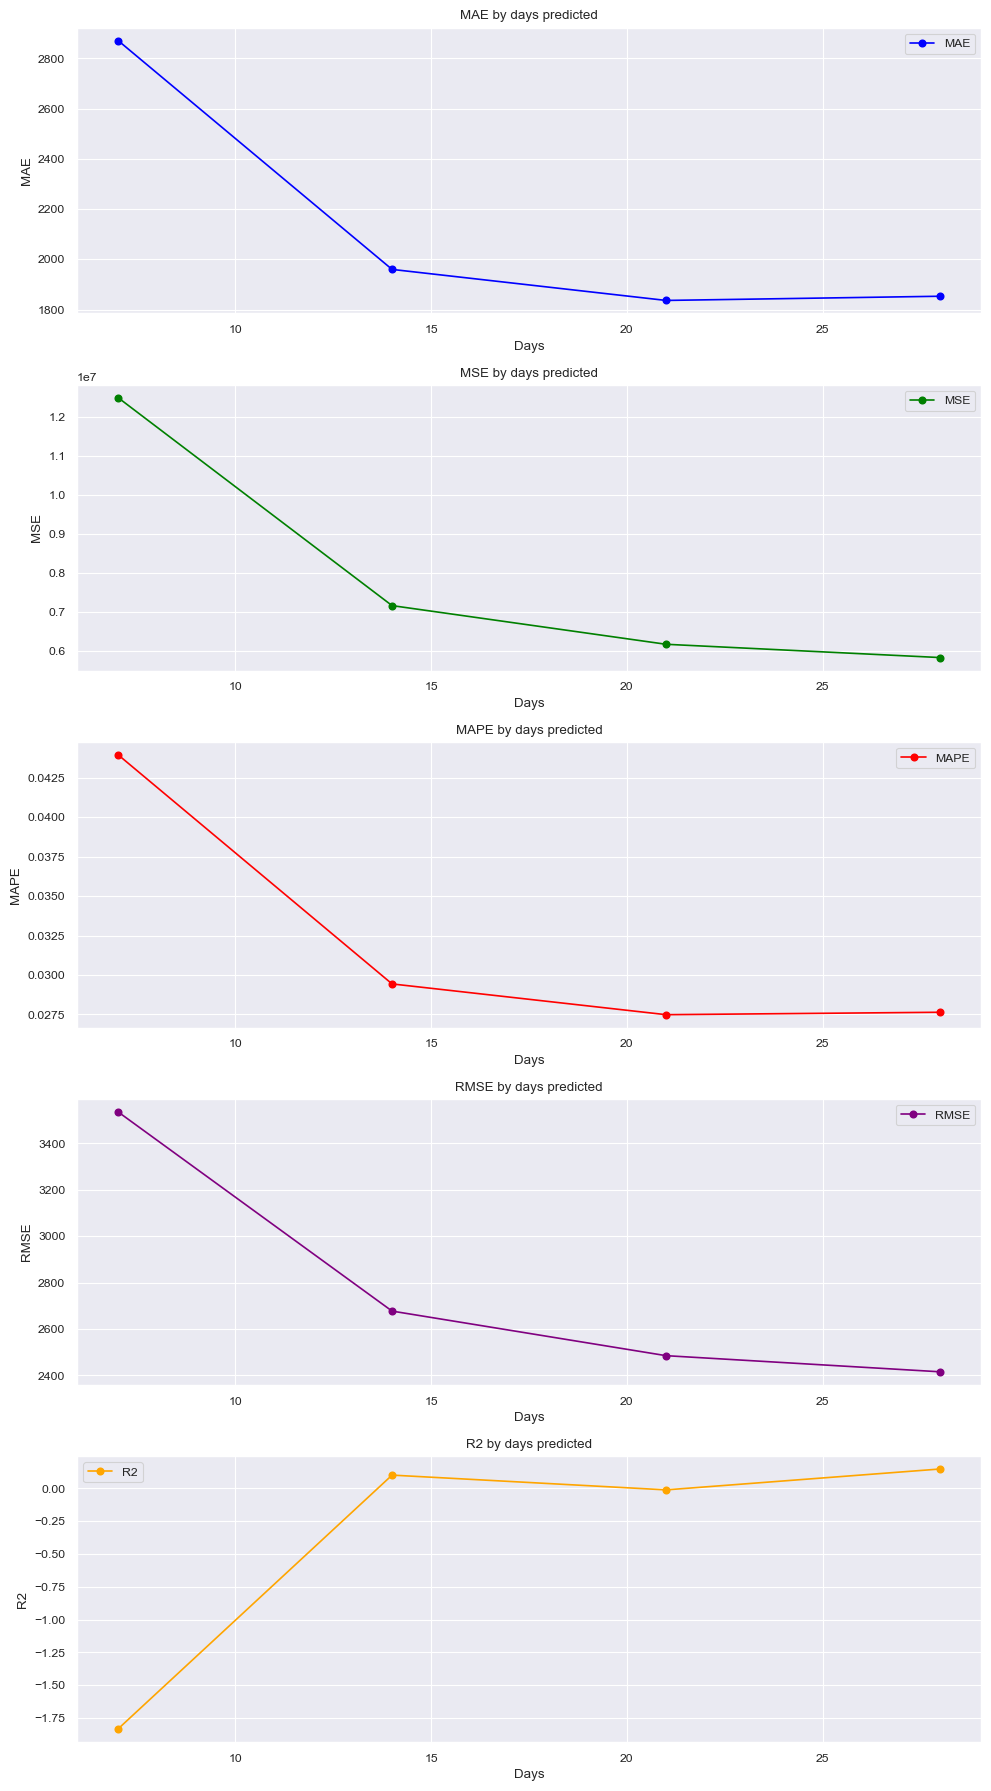

In [ ]:
roll_bic = forecast_accuracy(predictions_roll_bic, test_4w, title_prefix="Forecast")

In [ ]:
plot_prediction_correlation(test_4w, predictions_roll_bic)

Vemos que a excepcion de el intervalo de 7 días todoso tienen una tendencia positiva, ademas, el mejor R^2 esta en el intervalo de 28 dias.


#### Forecast

In [ ]:
test_range = range(4)
predictions_for_bic = []

for i in test_range:
    # Hacer las predicciones para el siguiente intervalo de tiempo
    num_steps = 7 * (i + 1)  # Calculando el número de pasos a predecir
    yhat = model_fit_bic.forecast(steps=num_steps)
    predictions_for_bic.append(yhat)

In [ ]:
results = analyze_residuals(predictions_for_bic,test_4w)

Residuos para la predicción de 7 días:
Test de Shapiro-Wilk P-Value: 0.4822
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.0864
No rechazar la hipótesis nula: Los residuos parecen ser independientes.


Residuos para la predicción de 14 días:
Test de Shapiro-Wilk P-Value: 0.1098
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.0435
Rechazar la hipótesis nula: Los residuos muestran autocorrelación significativa.


Residuos para la predicción de 21 días:
Test de Shapiro-Wilk P-Value: 0.1307
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.1106
No rechazar la hipótesis nula: Los residuos parecen ser independientes.


Residuos para la predicción de 28 días:
Test de Shapiro-Wilk P-Value: 0.0391
Rechazar la hipótesis nula: Los residuos no son normales.
Test de Ljung-Box P-Value: 0.0419
Rechazar la hipótesis nula: Los residuos muestran autocorrelación sign

Observamos que a diferencia del rolling forecast el supuesto de independencia no se cumple para algunos intervalos de tiempo, se necesita una investigacion en el tema pero para ambitos educativos trabajaremos asi.

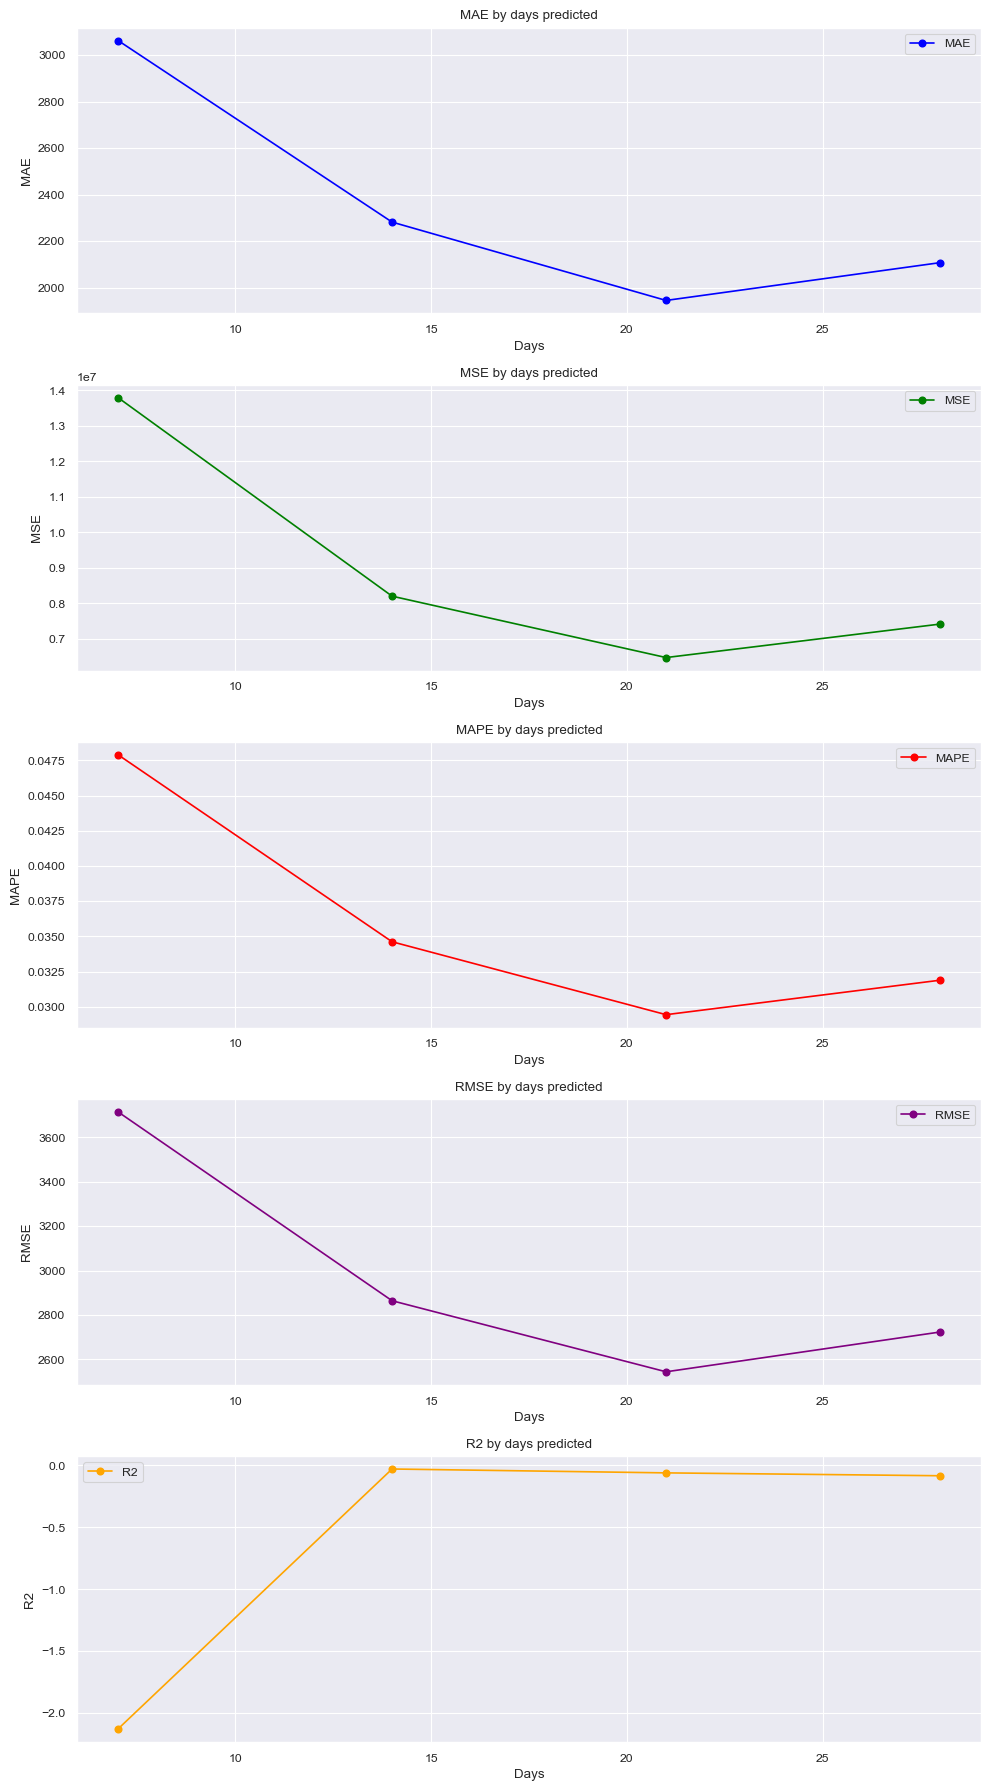

In [ ]:
for_bic = forecast_accuracy(predictions_for_bic, test_4w, title_prefix="Forecast")

Parece que el mejor intervalo es a 21 días.

In [ ]:
plot_prediction_correlation(test_4w, predictions_for_bic)

#### Comparaciones

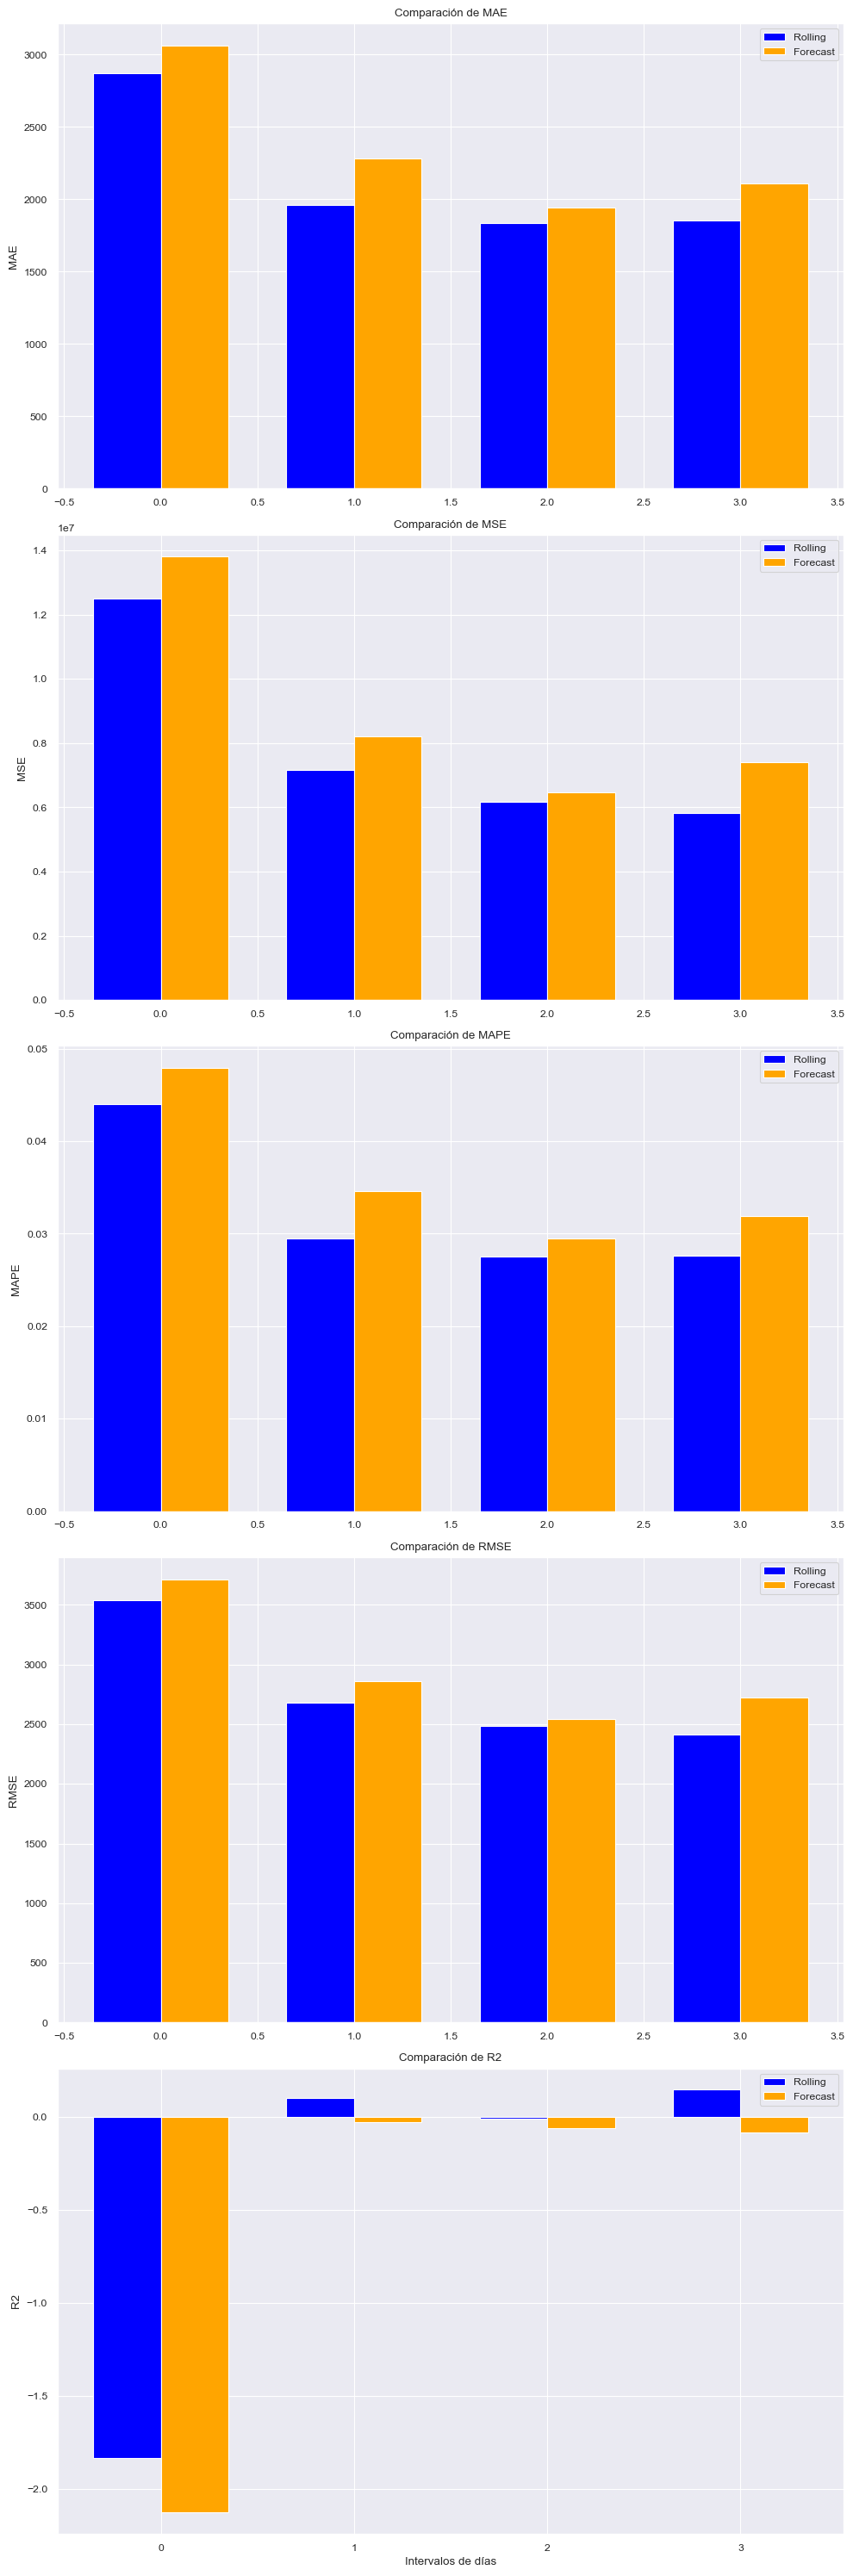

In [ ]:
plot_comparative_metrics(roll_bic, for_bic)

El rolling forecast es mejor, puesto que minimiza errores

### HQIC

In [ ]:
best_hqic = np.inf

best_order = None
best_mdl = None

pq_rng = range(5)
d_rng  = range(3)

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                # print(i, d, j)
                tmp_mdl = ARIMA(train, order=(i,d,j)).fit()
                tmp_hqic = tmp_mdl.hqic
                if tmp_hqic < best_hqic:
                    best_hqic = tmp_hqic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

Hyperparametrizamos optimizando el HQIC

In [ ]:
print('HQIC: {:6.5f} | order: {}'.format(best_hqic, best_order))

HQIC: 56313.45958 | order: (3, 2, 4)


In [ ]:
model_hqic = ARIMA(train, order=best_order)
model_fit_hqic = model_hqic.fit()

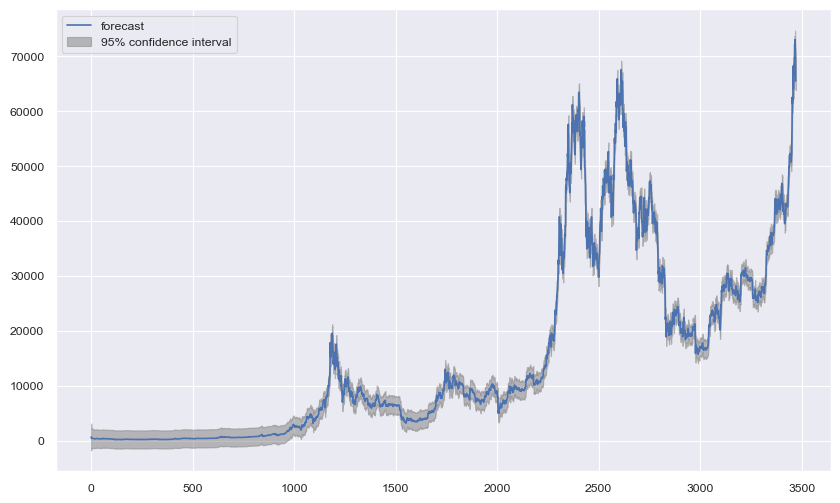

In [ ]:
plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots();
plot_predict(model_fit_hqic, 1, ax=ax);
plt.show();

Graficamos el intervalo de confianza del 95%

#### Rolling Forecast

In [ ]:
test_range = range(4)
predictions_roll_hqic = []
for i in test_range:
    test = test_4w.head(7*(i+1))
    test = test.tolist()
    yhat  = arima_rolling(train.tolist(), test, best_order)
    predictions_roll_hqic.append(yhat)

Hacemos el rolling forecast para el nuevo modelo

In [ ]:
results = analyze_residuals(predictions_roll_hqic,test_4w)

Residuos para la predicción de 7 días:
Test de Shapiro-Wilk P-Value: 0.7373
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.1296
No rechazar la hipótesis nula: Los residuos parecen ser independientes.


Residuos para la predicción de 14 días:
Test de Shapiro-Wilk P-Value: 0.4232
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.3658
No rechazar la hipótesis nula: Los residuos parecen ser independientes.


Residuos para la predicción de 21 días:
Test de Shapiro-Wilk P-Value: 0.3687
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.5013
No rechazar la hipótesis nula: Los residuos parecen ser independientes.


Residuos para la predicción de 28 días:
Test de Shapiro-Wilk P-Value: 0.7656
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.5265
No rechazar la hipótesis nula: Los residuos parecen ser independientes.

Cumple todos los supuestos.

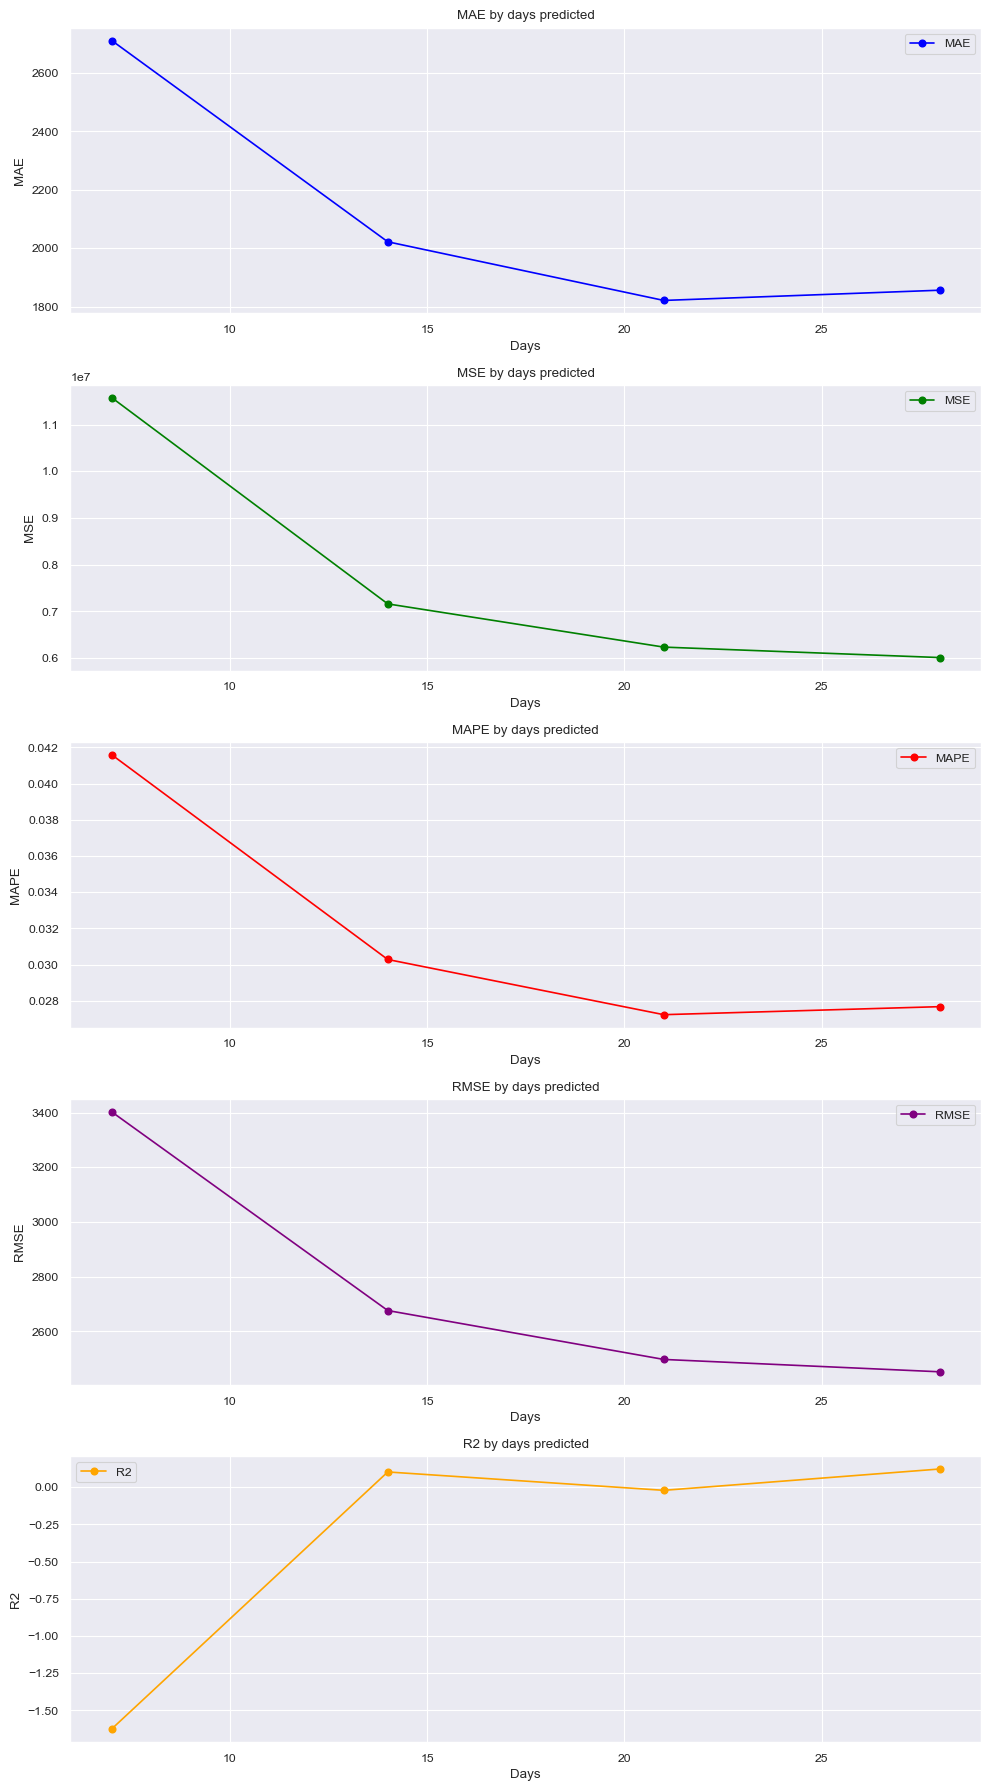

In [ ]:
roll_hqic = forecast_accuracy(predictions_roll_hqic, test_4w, title_prefix="Forecast")

Graficamos.

Se observa que el R^2 tiene valores negativos.

In [ ]:
plot_prediction_correlation(test_4w, predictions_roll_hqic)

Vemos que a excepcion de el intervalo de 7 días todoso tienen una tendencia positiva, ademas, el mejor R^2 esta en el intervalo de 28 dias.


#### Forecast

In [ ]:
test_range = range(4)
predictions_for_hqic = []

for i in test_range:
    # Hacer las predicciones para el siguiente intervalo de tiempo
    num_steps = 7 * (i + 1)  # Calculando el número de pasos a predecir
    yhat = model_fit_hqic.forecast(steps=num_steps)
    predictions_for_hqic.append(yhat)

In [ ]:
results = analyze_residuals(predictions_for_hqic,test_4w)

Residuos para la predicción de 7 días:
Test de Shapiro-Wilk P-Value: 0.3997
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.0792
No rechazar la hipótesis nula: Los residuos parecen ser independientes.


Residuos para la predicción de 14 días:
Test de Shapiro-Wilk P-Value: 0.1172
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.0402
Rechazar la hipótesis nula: Los residuos muestran autocorrelación significativa.


Residuos para la predicción de 21 días:
Test de Shapiro-Wilk P-Value: 0.1362
No rechazar la hipótesis nula: Los residuos parecen ser normales.
Test de Ljung-Box P-Value: 0.1099
No rechazar la hipótesis nula: Los residuos parecen ser independientes.


Residuos para la predicción de 28 días:
Test de Shapiro-Wilk P-Value: 0.0445
Rechazar la hipótesis nula: Los residuos no son normales.
Test de Ljung-Box P-Value: 0.0416
Rechazar la hipótesis nula: Los residuos muestran autocorrelación sign

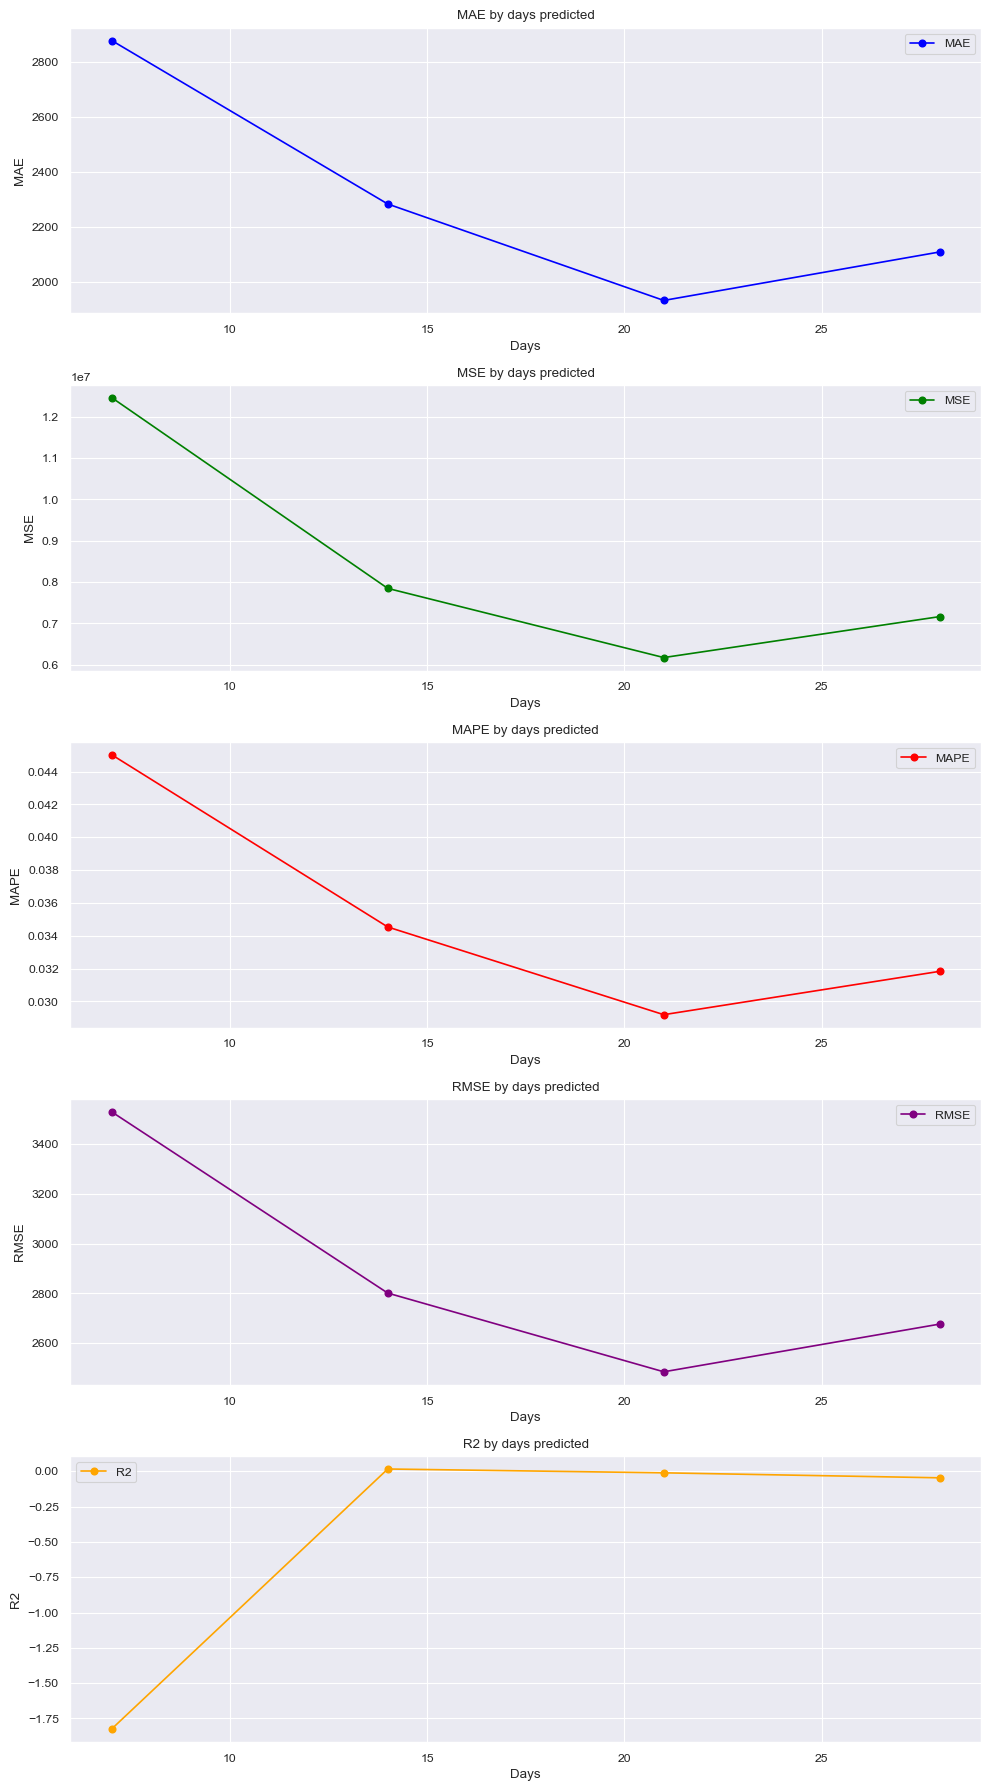

In [ ]:
for_hqic = forecast_accuracy(predictions_for_hqic, test_4w, title_prefix="Forecast")

In [ ]:
plot_prediction_correlation(test_4w, predictions_for_hqic)

todos tienen una tendencia positiva.

#### Comparaciones

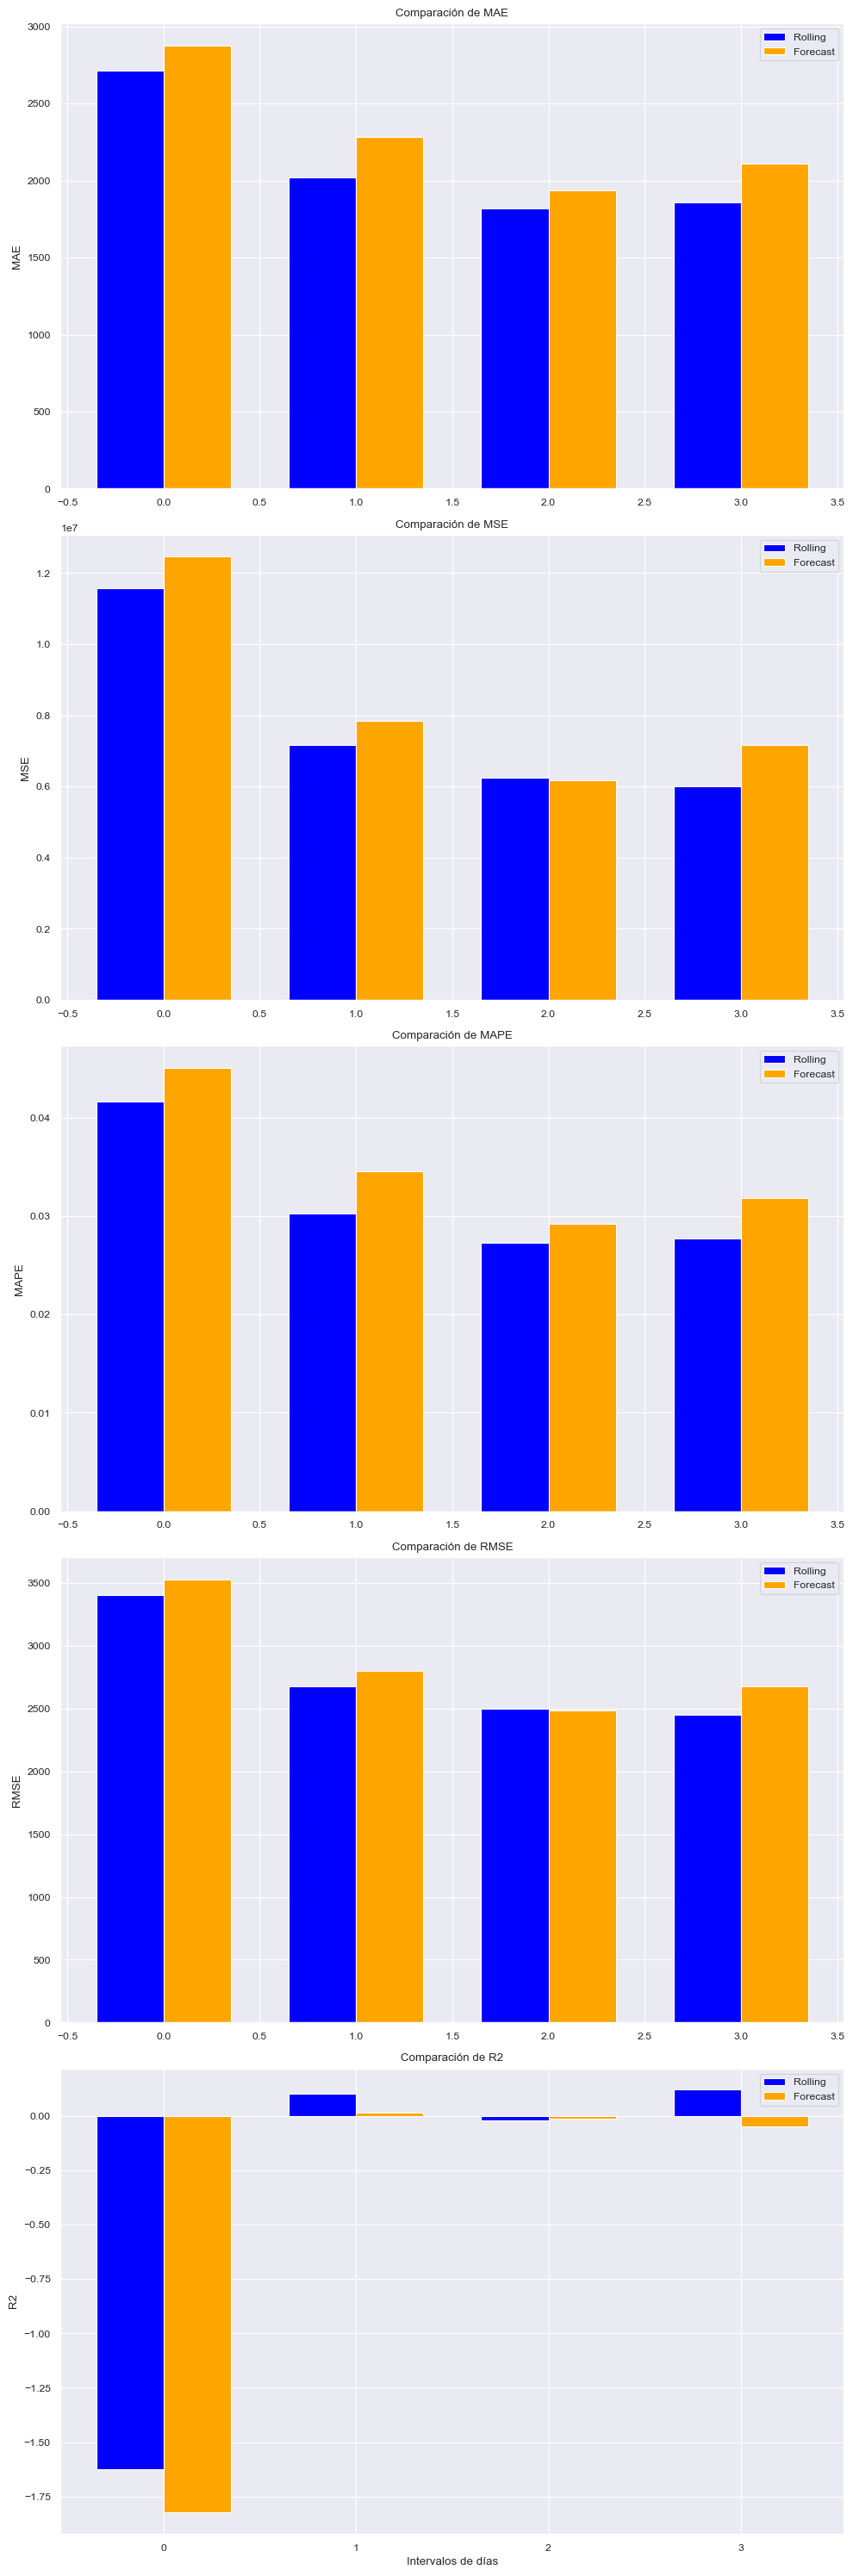

In [ ]:
plot_comparative_metrics(roll_aic, for_aic)

En terminos generales el rolling forecast se considera mejor porque reduce los errores

## Se realiza comparaciones

In [ ]:
import matplotlib.pyplot as plt

def plot_comparative_metrics_3(df1, df2, df3):
    metrics = ['MAE', 'MSE', 'MAPE', 'RMSE', 'R2']
    num_metrics = len(metrics)
    intervals = df1.index  # Asumimos que el índice es el intervalo de días
    width = 0.20  # Ancho de las barras, ajustado para acomodar tres modelos

    # Crear una figura grande para contener todos los subplots
    fig, axes = plt.subplots(nrows=num_metrics, ncols=1, figsize=(10, 6 * num_metrics))

    for i, metric in enumerate(metrics):
        ax = axes[i]  # Acceder al subplot correspondiente
        # Graficar las barras para DF1
        ax.bar(intervals - width, df1[metric], width, label='AIC', color='blue')
        # Graficar las barras para DF2
        ax.bar(intervals, df2[metric], width, label='BIC', color='orange')
        # Graficar las barras para DF3
        ax.bar(intervals + width, df3[metric], width, label='HQIC', color='green')

        ax.set_title(f'Comparación de {metric}')
        ax.set_ylabel(metric)
        ax.legend()

    axes[-1].set_xlabel('Intervalos de días')  # Etiqueta del eje x solo en el último gráfico
    axes[-1].set_xticks(intervals)  # Asegurar que todos los intervalos estén etiquetados

    plt.tight_layout()
    plt.show()

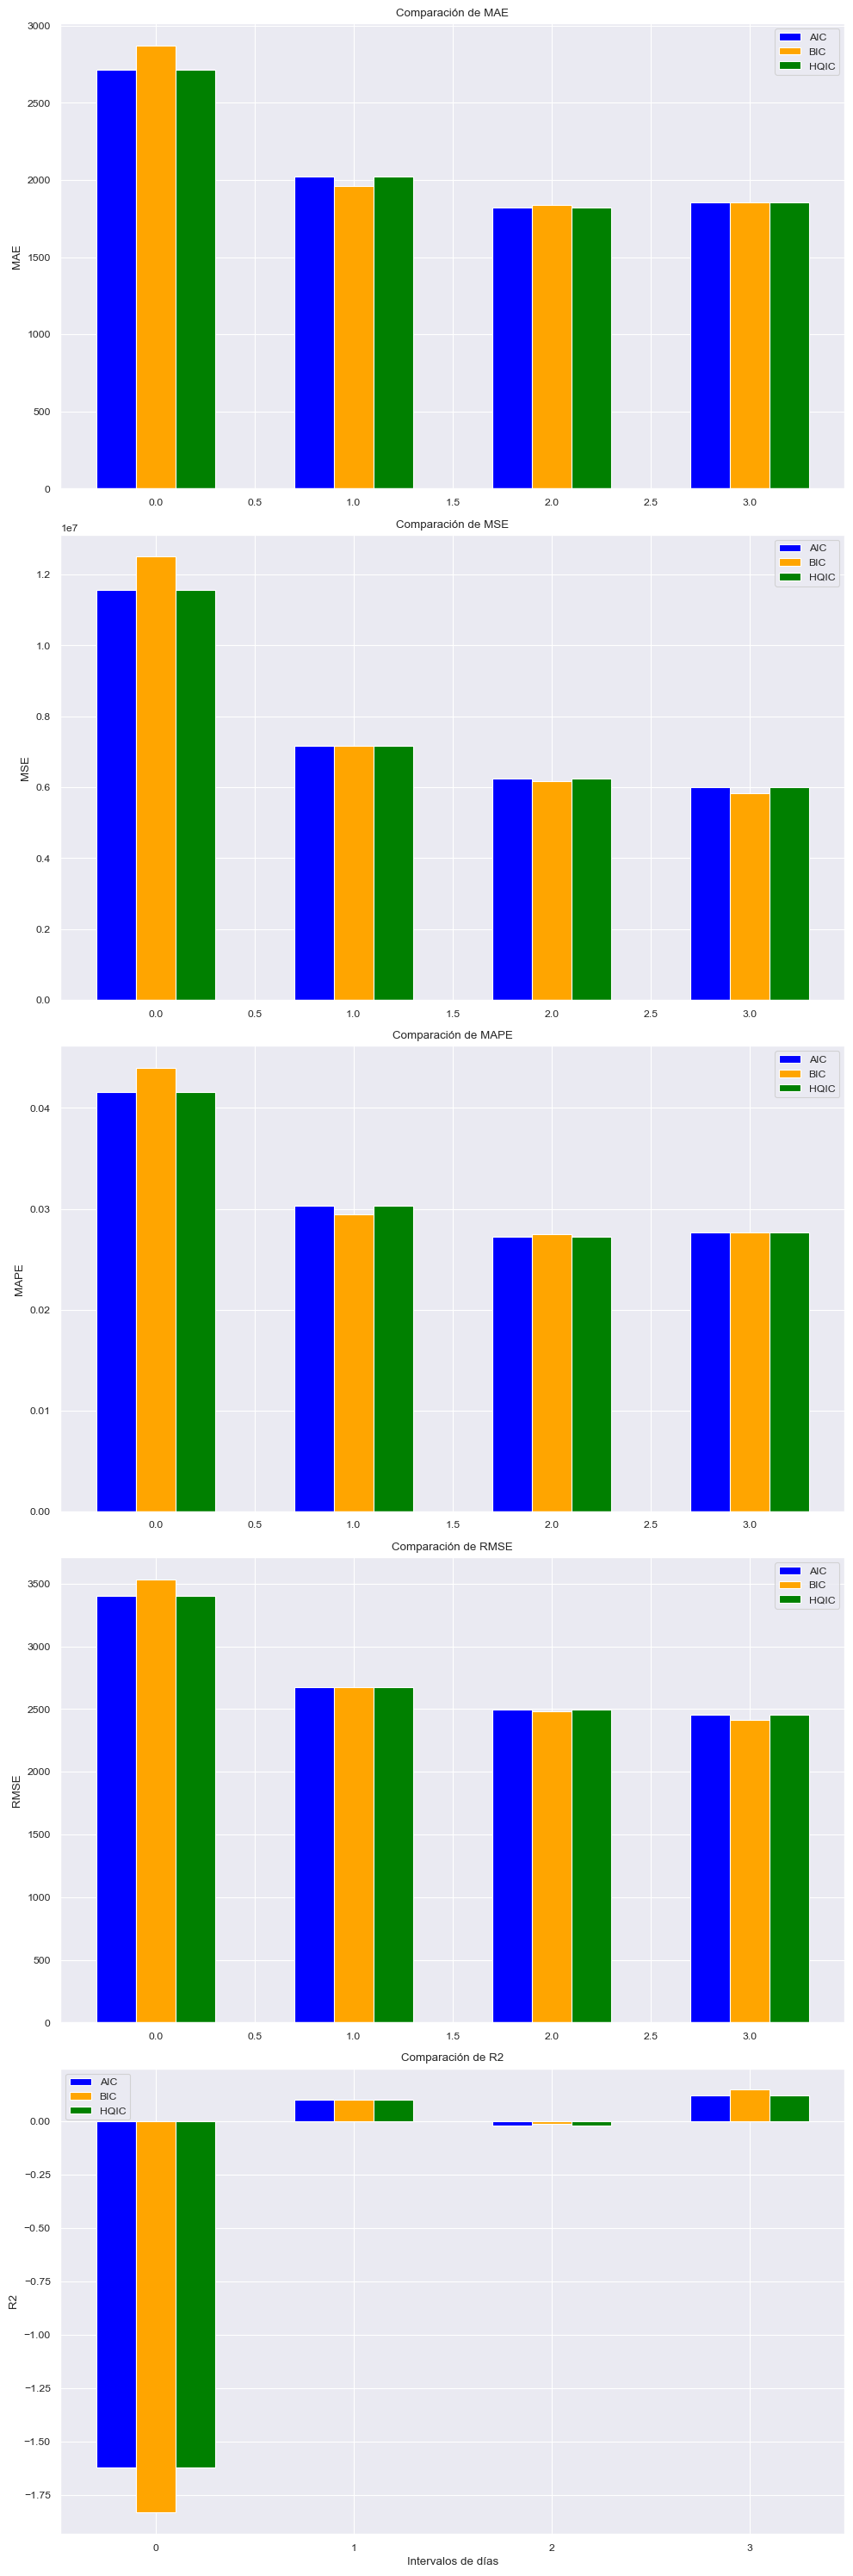

In [ ]:
plot_comparative_metrics_3(roll_aic, roll_bic, roll_hqic)